# Transform the Result SR images to add to dataset

In [1]:
import os
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import json
from datetime import datetime

## Make X2 annotation

### Check annotation size

In [2]:
# Dataset path
dataDir = '/data/ephemeral/home/sr_dataset'
annotation_path = '/data/ephemeral/home/dataset/train.json'

loading annotations into memory...
Done (t=0.15s)
creating index...
index created!


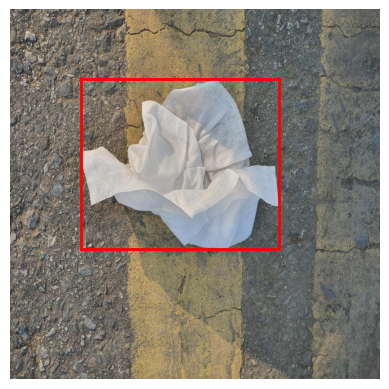

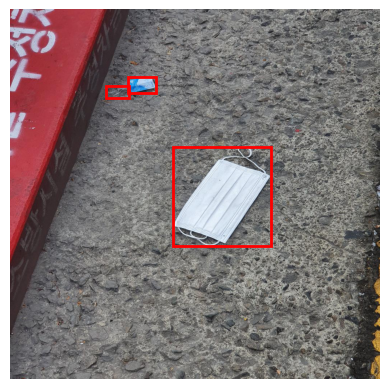

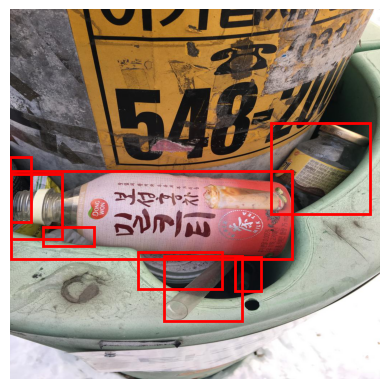

In [3]:
# Initialize COCO object
coco = COCO(annotation_path)
for idx in os.listdir(os.path.join(dataDir,'train')):
    img = coco.loadImgs(int(idx.split('_')[0]))[0]

    # Load image
    I = cv.imread('{}/{}.'.format(dataDir, img['file_name'].split('.')[0]))
    plt.imshow(I)
    plt.axis('off')

    # annotation ID
    annIds = coco.getAnnIds(imgIds=img['id'], iscrowd=None)
    anns = coco.loadAnns(annIds)

    # # Draw original bounding box
    # ax = plt.gca()
    # for ann in anns:
    #     bbox = ann['bbox']
    #     rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='r', facecolor='none')
    #     ax.add_patch(rect)
    # plt.show()

    # Draw X2 bounding box
    plt.imshow(I)
    plt.axis('off')

    ax = plt.gca()
    for ann in anns:
        bbox = ann['bbox']
        rect = patches.Rectangle((bbox[0]*2, bbox[1]*2), bbox[2]*2, bbox[3]*2, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    plt.show()

### Make SR dataset annotation file

In [3]:
x2_annotation_path = '/data/ephemeral/home/sr_dataset/train_x2_SR.json'

# Read json
with open(annotation_path, 'r') as file:
    data = json.load(file)

# Modify bbox values
for ann in data['annotations']:
    ann['bbox'][0] *= 2
    ann['bbox'][1] *= 2
    ann['bbox'][2] *= 2
    ann['bbox'][3] *= 2

# Store new json file
with open(x2_annotation_path, 'w') as file:
    json.dump(data, file, indent=2)

## Divide the image into quarters

In [4]:
# Dataset path
dataDir = '/data/ephemeral/home/sr_dataset'
annotation_path = '/data/ephemeral/home/sr_dataset/train_x2_SR.json'
original_anno_path = '/data/ephemeral/home/dataset/train.json'

# saved path
subimgs_path = '/data/ephemeral/home/sr_dataset/subimages'
updated_annotation_path = '/data/ephemeral/home/sr_dataset/train_x2_SR_4images.json'

loading annotations into memory...
Done (t=0.08s)
creating index...
index created!


KeyboardInterrupt: 

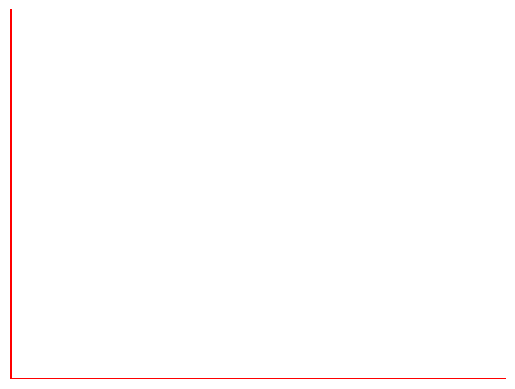

In [6]:
def update_annotations_for_subimage(annotations, subimg_info, img_id):
    updated_annotations = []
    x_offset, y_offset, subimg_width, subimg_height = subimg_info

    for ann in annotations:
        x, y, width, height = ann['bbox']

        # BBox가 subimg 영역과 겹치는지 확인
        if (x + width > x_offset and x < x_offset + subimg_width and
            y + height > y_offset and y < y_offset + subimg_height):
            
            # Update BBox coordinate
            new_x = max(x - x_offset, 0)
            new_y = max(y - y_offset, 0)
            width = min(width, x+width - x_offset)
            height = min(height, y+height - y_offset)

            updated_ann = ann.copy()
            updated_ann['bbox'] = [new_x, new_y, width, height]
            updated_ann['image_id'] = img_id
            updated_annotations.append(updated_ann)
    
    return updated_annotations

# Read annotation file
with open(annotation_path, 'r') as file:
    data = json.load(file)

# Define new images and annotations
new_images = []
new_annotations = []
new_img_id = max([img['id'] for img in data['images']]) + 1

# Load images
coco = COCO(annotation_path)
for idx in os.listdir(os.path.join(dataDir,'train')):
    img = coco.loadImgs(int(idx.split('_')[0]))[0]
    I = Image.open('{}/{}_x2_SR.png'.format(dataDir, img['file_name'].split('.')[0]))
    img_width, img_height = I.size

    # annotation ID
    annIds = coco.getAnnIds(imgIds=img['id'], iscrowd=None)
    anns = coco.loadAnns(annIds)

    # 이미지를 4등분하는 영역 정의
    subimages = [
        (0, 0, img_width // 2, img_height // 2),  # 상단 왼쪽
        (img_width // 2, 0, img_width // 2, img_height // 2),  # 상단 오른쪽
        (0, img_height // 2, img_width // 2, img_height // 2),  # 하단 왼쪽
        (img_width // 2, img_height // 2, img_width // 2, img_height // 2)  # 하단 오른쪽
    ]

    # Update annotations for each partial image
    for i, subimg_info in enumerate(subimages):
        updated_anns = update_annotations_for_subimage(anns, subimg_info, new_img_id)

        # Draw X2 bounding box
        x_offset, y_offset, subimg_width, subimg_height = subimg_info
        subimg = I.crop((x_offset, y_offset, x_offset + subimg_width, y_offset + subimg_height))
        # plt.imshow(subimg)
        plt.axis('off')
        
        ax = plt.gca()
        for ann in updated_anns:
            bbox = ann['bbox']
            rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
        # plt.show()

        subimg_filename = '{}_{}_x2_SR.png'.format(img['file_name'].split('.')[0], i)
        # annotation file updated
        if updated_anns:
            new_img = {
                "width": subimg_width,
                "height": subimg_height,
                "file_name": subimg_filename,
                "license": 0,
                "flickr_url": None,
                "coco_url": None,
                "date_captured": datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
                "id": new_img_id
            }
            new_images.append(new_img)
            new_annotations.extend(updated_anns)

            # bbox가 있는 경우만 subimg 저장 
            subimg.save(os.path.join(subimgs_path, subimg_filename))
        
            new_img_id += 1

# 추가는 train.json 파일로 해야함
with open(original_anno_path, 'r') as file:
    original_data = json.load(file)

original_data['images'].extend(new_images)
original_data['annotations'].extend(new_annotations)

with open(updated_annotation_path, 'w') as file:
    json.dump(original_data, file, indent=2)